<a href="https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/FerroNet/FerroicBlocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Analysis of the Atomic-Scale Ferroelectric Distortions

**Notebook prepared by Maxim Ziatdinov**

E-mail: ziatdinovmax@gmail.com


In this notebook, I will show how using the deep-learning analysis it is possible to identify the localization of atomic columns in the form of the probability density field and further explore the use of several linear statistical unmixing techniques including Gaussian mixture models and independent component analysis to build the library of structural distortions and the associated domain structures.

## Import/install python modules

This should not take more than several minutes.

We start by installing necessary python modules and downloading files specific to this analysis from the corresponding github repositories (such as experimental data, neural network skeleton,  trained weights).

In [0]:
nbtype = !python -c "import google.colab" 2>/dev/null; echo $?
if not int(nbtype[0]):
    !git clone https://github.com/pycroscopy/AICrystallographer.git
    !cp -r AICrystallographer/FerroNet/* . 
!sh packages.sh modules

Cloning into 'AICrystallographer'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1541 (delta 51), reused 39 (delta 16), pack-reused 1444
Receiving objects: 100% (1541/1541), 163.88 MiB | 34.06 MiB/s, done.
Resolving deltas: 100% (834/834), done.
Checking out files: 100% (274/274), done.
Checking if PyTorch sees Colab GPU device...
Available GPU devices:
Tesla T4


Installing packages for vizualization of neural networks -->

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-h096doec
  Running command git clone -q https://g

Here we import all necessary python modules:

In [0]:
# I/O, data manipulation and plotting
import os
import time
import numpy as np
from sklearn.utils import shuffle
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
if not int(nbtype[0]):
    from google.colab import files

In [0]:
# neural networks
import torch
import dcnn
from utils import *

In [0]:
# clustering/unmixing and dimensionality reduction
from sklearn import mixture, cluster
from sklearn import decomposition, manifold

## Image processing with deep learning

### Neural network training

**Important**: *in this notebook we provide an already trained model and therefore one can skip this code section (i.e. model training) and go directly to the next code section titled 'Inference on experimental data'.*

We start with downloading our training data (~1-2 minutes):

In [0]:
%%shell
sh AICrystallographer/FerroNet/packages.sh dataset

We also import packages for model vizualization:

In [0]:
# vizualization tools for neural networks
import pydot
from torchviz import make_dot

Next we initialize our neural network. It has a contracting path consisting of regular convolutional operations followed by max-pooling operation, a bottleneck layer with three layers of atrous convolutions with different dilation rates, and an expanding path with bilinear upsampling that has the same convolutional blocks as the contracting path but in a reversed order. The skip connections provide a flow of information between contracting and expanding pathes.The final layer provides a pixel wise classification of the input data.

In [0]:
model = dcnn.ferronet(nb_classes = 3)

We can visualize the model that we just initialized (entirely optional - feel free to skip this step and go directly to model compilation and training):

In [0]:
x = torch.randn(1, 1, 256, 256).requires_grad_(False)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

Next we compile our model:

In [0]:
# Move the initialized model to GPU
model.cuda()
# specify loss function
criterion = torch.nn.NLLLoss()
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)

We are now going to train a model for cleaning image data and and idenifying different types of atoms in a square bipartite system. We specify a path/filename for the training set that we have downloaded and a batch size:

In [0]:
# Training data filepath:
hf_file = 'BFO-ts1-512.hdf5'
# batch size:
batch_size = 30

We initialize a batch generator and produce a batch of training images with corresponding ground truth for illustration purposes:

In [0]:
gen = generate_batches(hf_file, batch_size)
train_imgs, gt = next(gen.batch(0))
gen.close_()

Here we plot the produced  training image - ground truth pair:

(notice that this is a training set for two interlocked square lattices not specific to the material of the current study )

In [0]:
k = -2
fig, ax = plt.subplots(1,2, figsize = (8, 8))
ax[0].imshow(train_imgs[k, 0, :, :], cmap = 'gray')
ax[0].set_title('Training image')
ax[1].imshow(gt[k], cmap = 'RdBu', interpolation = 'Gaussian')
ax[1].set_title('Ground truth')

Finally, we train our model.

*Notice that when we train a model using simulated data and later want to apply it to experimental data, the only validation that matters is model perfomance on experimental data afterwads*. There can be situations when a model performs very nicely on a simulated 'validation set' and then fails on real experimental data.

In [0]:
# Choose number of training epochs
epochs = 64

train_losses, test_losses = [], []
# Initiate batch generator. Notice that we will be 
# randomly changing images size during the model training
gen = generate_batches(hf_file, batch_size, (256-64, 256+64+1, 32))
steps = gen.steps()
steps_val = gen.steps(mode = 'val')
# Train a model 
for e in range(epochs):
    print("\nEpoch {}/{}".format(e+1, epochs)) 
    # Training mode
    model.train()
    running_loss_train = 0
    start = time.time()
    steps = shuffle(steps)
    for i, s in enumerate(steps):
        print("\rTraining mode", 4*".",
              "Batch {}/{}".format(i+1, len(steps)),
              end = "")
        # get image-ground truth pair
        images, labels = next(gen.batch(s))
        # transfer the pair to a gpu device
        images, labels = images.cuda(), labels.cuda() 
        # zero the parameter gradients
        optimizer.zero_grad() 
        # forward --> backward --> optimize
        log_prob = model.forward(images)
        loss = criterion(log_prob, labels)
        running_loss_train += loss.item() 
        loss.backward()
        optimizer.step()    
    
    # Evaluate current on a validation set
    else: 
        time_per_batch = (time.time()-start)/len(steps)
        # Validation ode
        model.eval()
        running_loss_test = 0
        print()
        # Disable gradient information
        with torch.no_grad():
            for i, s in enumerate(steps_val):
                print("\rValidation mode", 4*".",
                      "Batch {}/{}".format(i+1, len(steps_val)),
                      end = "")
                # Forward path (no backprop)
                images, labels = next(gen.batch(s, mode='val'))
                images, labels = images.cuda(), labels.cuda()
                log_prob = model.forward(images)
                loss = criterion(log_prob, labels)
                running_loss_test += loss.item()  
        train_losses.append(running_loss_train/len(steps))
        test_losses.append(running_loss_test/len(steps_val))
        
        # print statistics        
        print("\nTraining loss: {:.4f}".format(train_losses[-1]),
             8*".", "Test loss: {:.4f}".format(test_losses[-1]),
             8*".", "Time per batch: {:.2f} {}".format(time_per_batch, "s"))
         
    # save model weights if validation loss has decreased
    if e > 0 and test_losses[e] < min(test_losses[:e]):
        print("Saving checkpoint weights...")
        torch.save(model.state_dict(), 'atomfinder-'+
                   hf_file.split('.')[0]+'-1-best_weights.pt')
    if e == epochs-1:
        print('\nFinished model training')

# save the final weights
torch.save(model.state_dict(), 'atomfinder-'+hf_file.split('.')[0]+'-1.pt')
gen.close_()

Plot test/train losses vs. epochs:

In [0]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(train_losses, '-o', label = 'Training loss')
ax.plot(test_losses, '-o', label = 'Test loss')
ax.set_title('Training history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc = 'upper right')

Download weights to your local machine (and/or google drive if you are on ChromeOS):

In [0]:
best_weights = 'atomfinder-' + hf_file.split('.')[0] + '-1-best_weights.pt'
final_weights = 'atomfinder-' + hf_file.split('.')[0] +'-1.pt'
if not int(nbtype[0]):
    files.download(best_weights)
    files.download(final_weights)

### Inference on experimental data

We will now use the trained network to make an inference on real experimental data. First we load the best weights from our trained network into a model skeleton. Notice that we already provide the trained weights together with this notebook and therefore if you do not want to train a model, you can just load the saved weights by running the cell below. Alternatively, if you did traine a model using this notebook, you may modify a filepath to load the weights of a model that you just trained (it is already there, you just need to uncomment the second line)

In [0]:
weights_filepath = 'saved_models/atomfinder-BFO-ts1-512-1-best_weights.pt'
#weights_filepath = 'atomfinder-BFO-ts1-512-1-best_weights.pt'
model = dcnn.ferronet(nb_classes = 3)
model = dcnn.load_torchmodel(weights_filepath, model)

Set a directory for saving figures, which we can later download to a local machine.

In [0]:
mdirectory = 'Figures/'
if not os.path.exists(mdirectory):
    os.makedirs(mdirectory)  

Choose the experimental image to work with and load it into the notebook:

In [0]:
dirname = 'exp_data/'
image_filename = '22.06.02_2.npy'
#image_filename = '21.03.42_2.npy' # another image
STEM_real = np.load(dirname+image_filename)
STEM_real = torch_format(STEM_real)

Make a prediction (pixel-wise):

In [0]:
X_prob = predict(STEM_real, model)

Plot results:

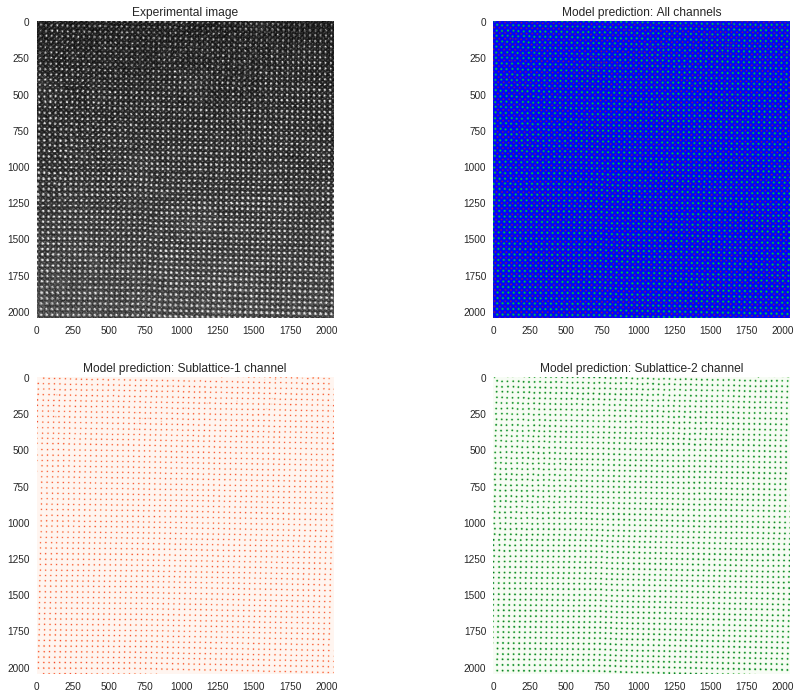

In [0]:
k = 0
fig, ax = plt.subplots(2, 2, figsize = (15, 12))
ax[0, 0].imshow(STEM_real[k, 0, :, :], cmap = 'gray')
ax[0, 0].set_title('Experimental image')
ax[0, 1].imshow(X_prob[k], Interpolation = 'Gaussian')
ax[0, 1].set_title('Model prediction: All channels')
ax[1, 0].imshow(X_prob[k,:,:,0]>0.5, cmap = 'Reds', Interpolation = 'Gaussian')
ax[1, 0].set_title('Model prediction: Sublattice-1 channel')
ax[1, 1].imshow(X_prob[k,:,:,1]>0.5, cmap = 'Greens', Interpolation = 'Gaussian')
ax[1, 1].set_title('Model prediction: Sublattice-2 channel')
for ax_ in fig.axes:
    ax_.grid(False)
fig.savefig(mdirectory+str(image_filename[0:-4])+'-network_output.png')

We were able to distinguish between two types of sublattices, which were imaged in the experiment. Notice that here we analyzed image with resolution of 2048*x*2048 even though our network was trained only using 256*x*256 images. That's the beauty of fully convolutional neural network (i.e. network without full-connected, dense layers) - it is not sensitive to the size of input image as long as it can be divided by $2^{n}$ where *n* is a number of max-pooling layers in your network.

For future analysis, it will be convenient to work with numpy array instead of pytorch tensors:

In [0]:
network_output = X_prob.numpy()

## Ferroic building blocks extraction

### Prepare data (extract sub-images)

We will analyze the output of a neural network with tools such as principal components analysis (PCA), k-means clustering, non-negative matrix factorization (NMF) and independent component analysis (ICA). The goal is to map different classes of distortions (if present) using information on local neghborhood of atoms/blobs in the network output.

Define a local neighborhood for the further analysis:

In [0]:
# image index (in this case we have only one image)
k = 0

# Get xy positions of atomic columns
com1 = find_com(network_output[k,:,:,0])
com2 = find_com(network_output[k,:,:,1])

# Estimate average distance between 2 nearest 
# lattice points from different sublattices
d0 = estimate_nnd(com1, com2)

# Estimate average size of a blob ("atom") 
# in the output of a neural network
ma0 = estimate_rad(network_output[k,:,:,1])

d0 = np.around(d0 + ma0)
print('Effective radius of one cell:', int(d0), 'px')

Average nearest-neighbor distance: 25.0
Average blob radius: 7.0
Effective radius of one cell: 32 px


Here we can visualize subimages for different effective cell size (to change the size, change `sc` variable):

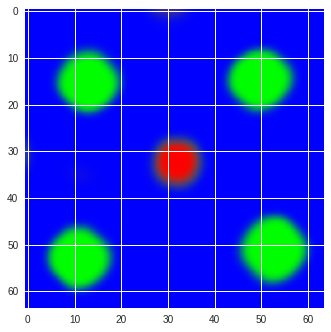

In [0]:
# Choose the effective cell size (sc = 1, 2, 3, ...)
sc = 1

d = int(0.5*(sc+1)*d0)
nb_classes = 3
img_cr_all, com_ = extract_subimages(
    network_output, com1, d, nb_classes, n = 500)
plt.imshow(img_cr_all[-1], Interpolation = 'Gaussian')

### Principal component analysis

We will now do principal component analysis (PCA) for different effective cell size and plot PCA scree plots as well as a variance for each of the first several PCA components for different effective cell sizes. 

**Caution:** This process may take some time (up to 30 min) and require large amounts of RAM (up to 12 GB). Since it is not critical to running other code sections, you may skip it.

In [0]:
# set the min and max values of the effective unit cell
d_min = 1
d_max = 4

nb_classes = 2 # we do not consider a background class
explained_var_all = np.empty((0, 30))
for i in range(d_min, d_max+1):
    d_ = int(0.5*(i+1)*d0)
    img_cr_all, _ = extract_subimages(
        network_output, com1, d_, nb_classes)
    # Flatten the image stack
    n, w, h, ch = img_cr_all.shape
    X_vec = img_cr_all.reshape(n, w*h*ch)
    # Perform PCA
    pca = decomposition.PCA()
    pca.fit(X_vec)
    explained_var = pca.explained_variance_ratio_ 
    explained_var = explained_var[0:30].reshape(1, -1)
    explained_var_all = np.append(explained_var_all, explained_var, axis = 0)

Plot the results:

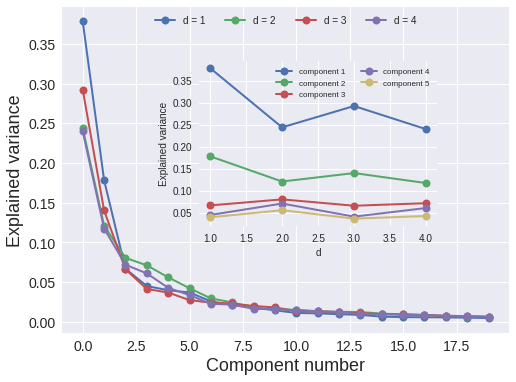

In [0]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
colors = color_list()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
axins = inset_axes(ax, 3.3, 2.3,
                   bbox_to_anchor=(0.3, 0.3, 0.55, 0.55),
                   bbox_transform=ax.transAxes)
r, xc = explained_var_all.shape
for i in range(r):  
    ax.plot(np.arange(xc)[0:20], explained_var_all[i, 0:20],
            '-o', linewidth=2, markersize=8,
            label='d = '+str(i+1))
    ax.legend(loc='upper center', ncol=d_max, frameon=False)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Explained variance')
ax.set_xlabel('Component number', fontsize=18)
ax.set_ylabel('Explained variance', fontsize=18) 
ax.tick_params(axis='both', labelsize=14)

for i in range(d_max+1):
    axins.plot(np.arange(r)+1, explained_var_all[:, i],
               '-o',linewidth=2,markersize=8,
               label = 'component '+str(i+1))
axins.legend(loc='best', ncol=2, fontsize=8, frameon=False)
axins.set_xlabel('d', fontsize = 10)
axins.set_ylabel('Explained variance', fontsize=10)
axins.tick_params(axis='both', labelsize=10)
fig.savefig(mdirectory+str(image_filename[0:-4])+'-PCAanalysis.png')

We will now run an exploratory analysis on the extracted image stack of the selected size (sc = 1).

In [0]:
# Choose the effective cell size
sc = 1

Prepare the data:

(*This image stack will be used for the rest of the analysis*)

In [0]:
d = int(0.5*(sc+1)*d0)
nb_classes = 2
img_cr_all, com_ = extract_subimages(
    network_output, com1, d, nb_classes)
n, w, h, ch = img_cr_all.shape
X_vec = img_cr_all.reshape(n, w*h*ch)

Here we will plot PCA eigenmodes with the associated loading maps for the selected number of PCA components:

NUMBER OF COMPONENTS: 4


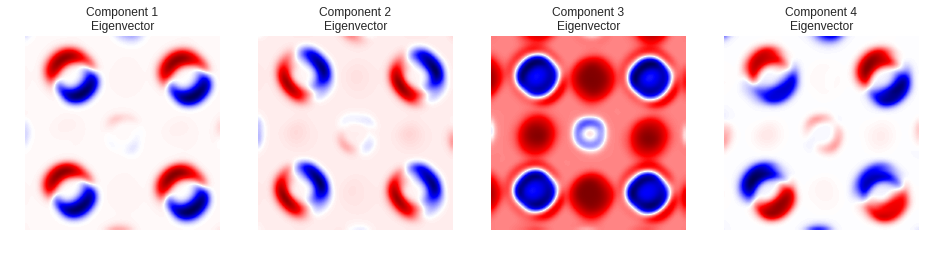

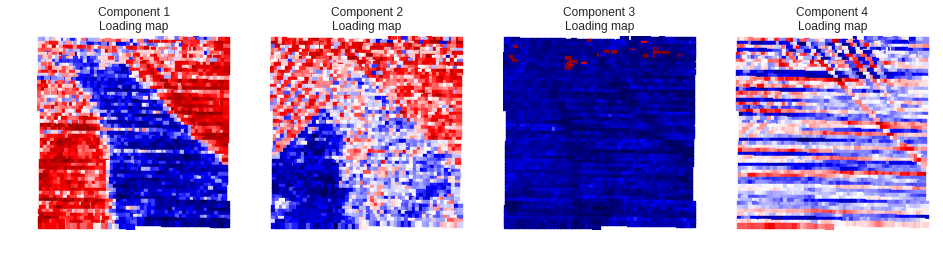

In [0]:
# specify number of components for PCA-based dimensionality reduction
nc = 4
img_w, img_h = network_output.shape[1:3]

# pca transformation
pca = decomposition.PCA(n_components=nc, random_state=42)
X_vec_t = pca.fit_transform(X_vec)
components = pca.components_
components = components.reshape(nc, w, h, ch)

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))
y, x = com_.T

print('NUMBER OF COMPONENTS: ' + str(nc))
# plot eigenvectors
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize=(4*cols, 4*(1+rows//2)))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    ax1.imshow(components[i, :, :, 0]+components[i, :, :, 1],
               cmap='seismic', Interpolation='Gaussian')
    ax1.set_aspect('equal')
    ax1.axis('off')
    ax1.set_title('Component '+str(i + 1)+'\nEigenvector')
fig1.savefig(mdirectory+str(image_filename[0:-4])+'-PCAmodes-n_cells'
             +str(sc)+'-n_components'+str(nc)+'.png')
plt.show()

#plot loading maps
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize=(4*cols, 4*(1+rows//2)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.scatter(x, y, c = X_vec_t[:, i], cmap='seismic', marker='s', s=32)
    ax2.set_xlim(0, img_w)
    ax2.set_ylim(img_h, 0)
    ax2.set_aspect('equal')
    ax2.axis('off')
    ax2.set_title('Component '+str(i+1)+'\nLoading map')
fig2.savefig(mdirectory+str(image_filename[0:-4])+'-PCAmaps-n_cells-'
             +str(sc)+'-n_components'+str(nc)+'.png')
plt.show()    

### k-means analysis

We plot 2D plot of features associated with the first two PCA components:

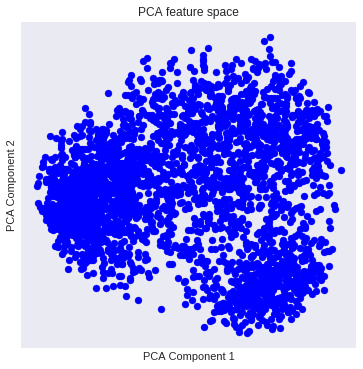

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_vec_t[:, 0], X_vec_t[:, 1], color='blue')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('PCA feature space')
fig.savefig(mdirectory+str(image_filename[0:-4])+
            '-PCAfeaturespace'+'-n_cells'+str(sc)+'.png')

The plot above suggests that the PCA features can be arranged into ~3 clusters. We therefore run k-means clustering on the features associated with the forst two PCA components:

In [0]:
n_clust = 3
clf = cluster.KMeans(
        n_clusters=n_clust, random_state=10).fit(X_vec_t[:, 0:2])
x, y = clf.cluster_centers_.T
labels = clf.predict(X_vec_t[:, 0:2])

We can plot the cluster centroids on top of PCA feature plot:

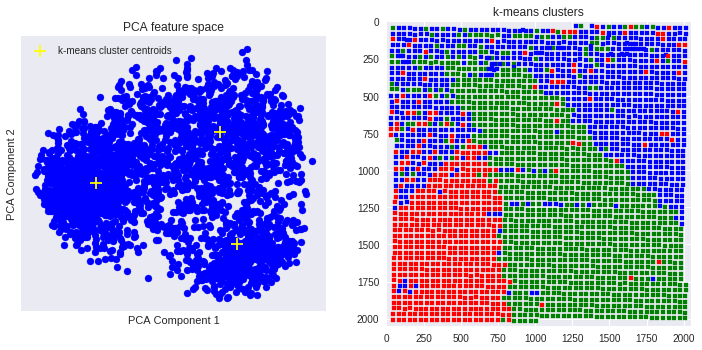

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
img_w, img_h = network_output.shape[1:3]
colors = color_list()
ax1.scatter(X_vec_t[:, 0], X_vec_t[:, 1], color = 'blue')
ax1.scatter(x, y, marker='+',s=160, c='yellow', label='k-means cluster centroids')
ax1.set_aspect('equal')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('PCA feature space')
ax1.legend()
for k in range(com_.shape[0]):
    ax2.scatter(com_[k][1], com_[k][0],
               c = colors[labels[k]], 
               marker='s', s=24)
    ax2.set_xlim(0, img_w)
    ax2.set_ylim(img_h, 0)
ax2.set_aspect('equal')
ax2.set_title('k-means clusters')
fig.savefig(mdirectory+str(image_filename[0:-4])+'-KMeans_on_PCA-n_clusters'
            +str(n_clust)+'-n_PCAcomponents'+str(nc)+'-n_cells'+str(sc)+'.png')

### Non-Negative Matrix Factorization

We next use a non-negative matrix factorization (NMF), which separates the mixture in non-negative components, corresponding to positive intensities for the image. Below we will run NMF for different total number of components and display the "endmembers" with the associated loading maps:

NUMBER OF COMPONENTS: 3


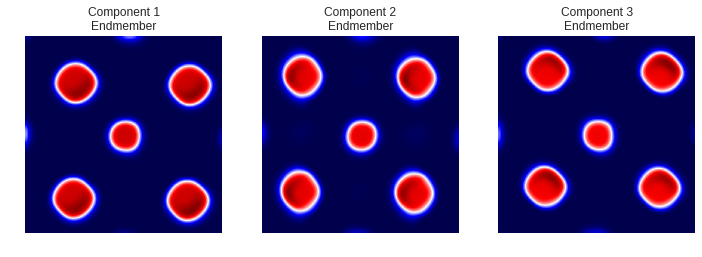

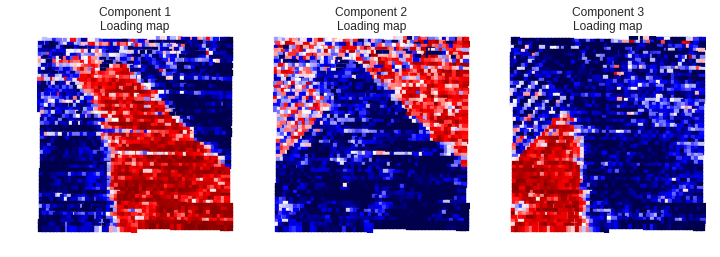

NUMBER OF COMPONENTS: 4


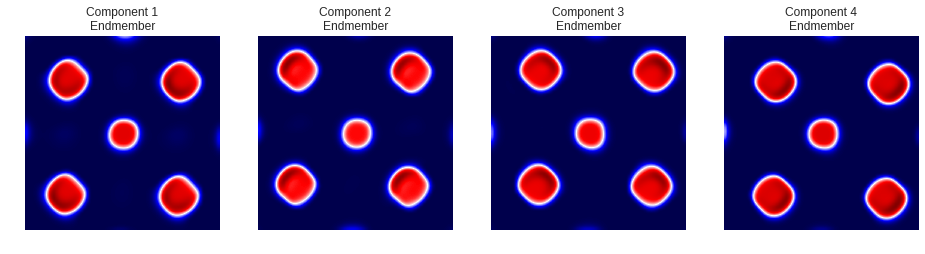

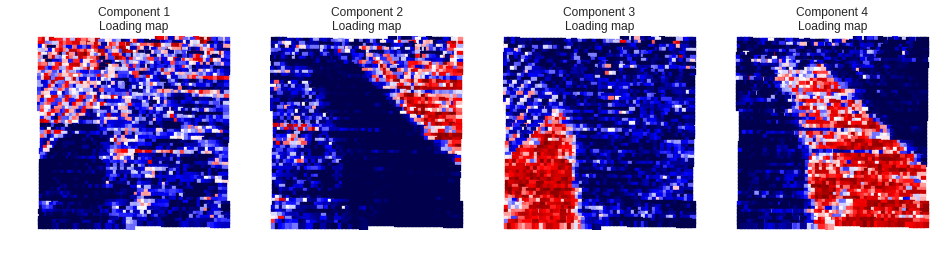

NUMBER OF COMPONENTS: 5


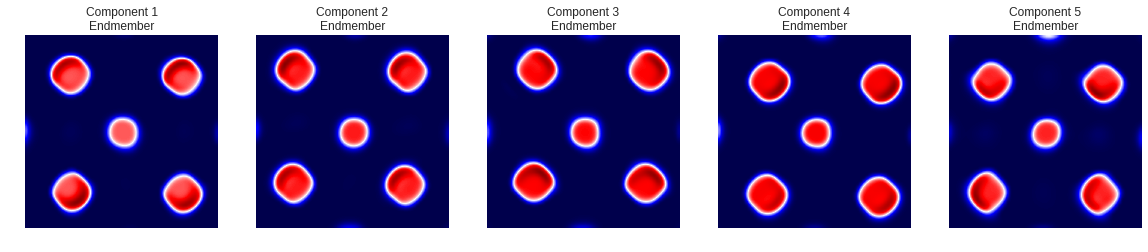

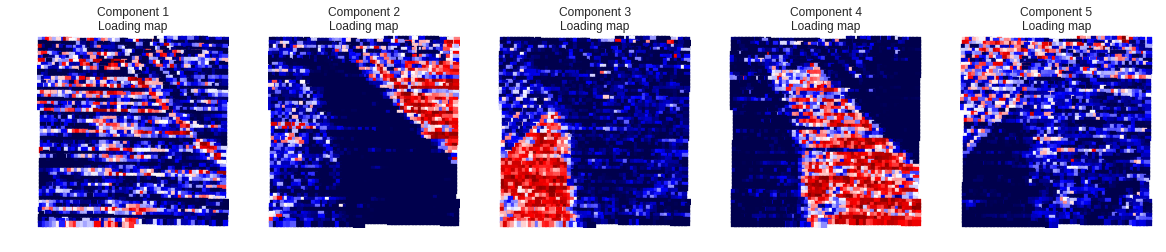

NUMBER OF COMPONENTS: 6


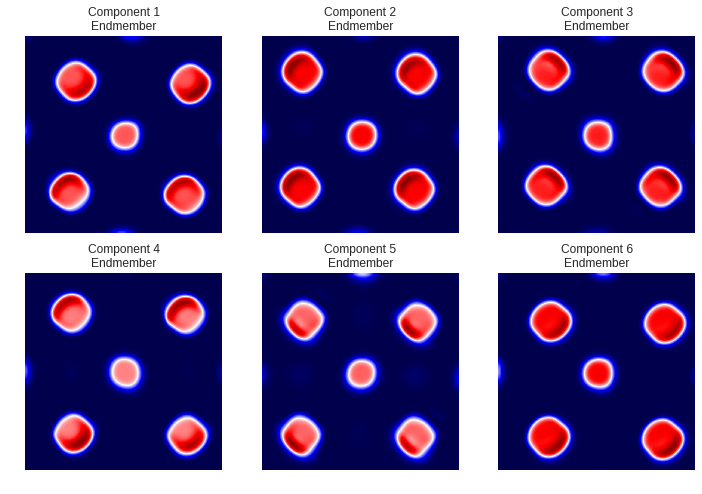

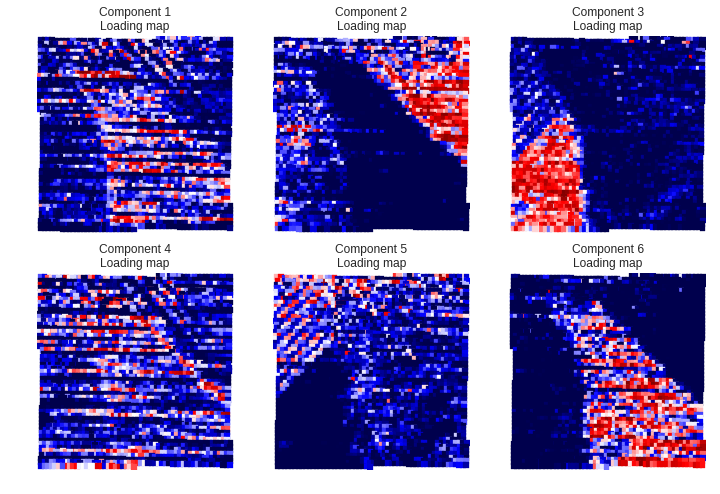

NUMBER OF COMPONENTS: 7


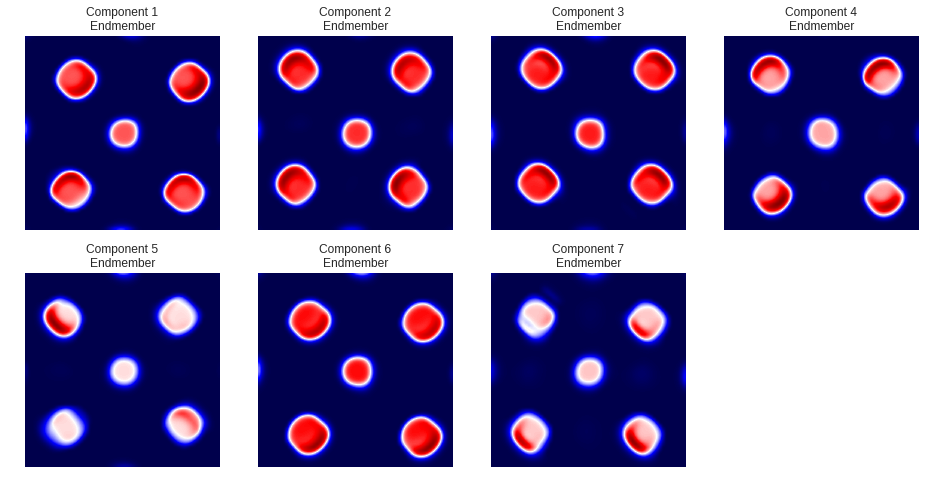

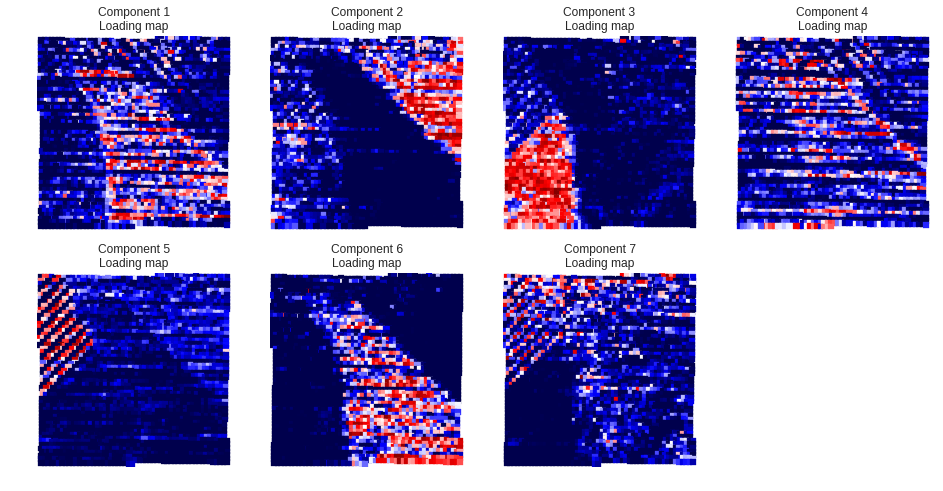

NUMBER OF COMPONENTS: 8


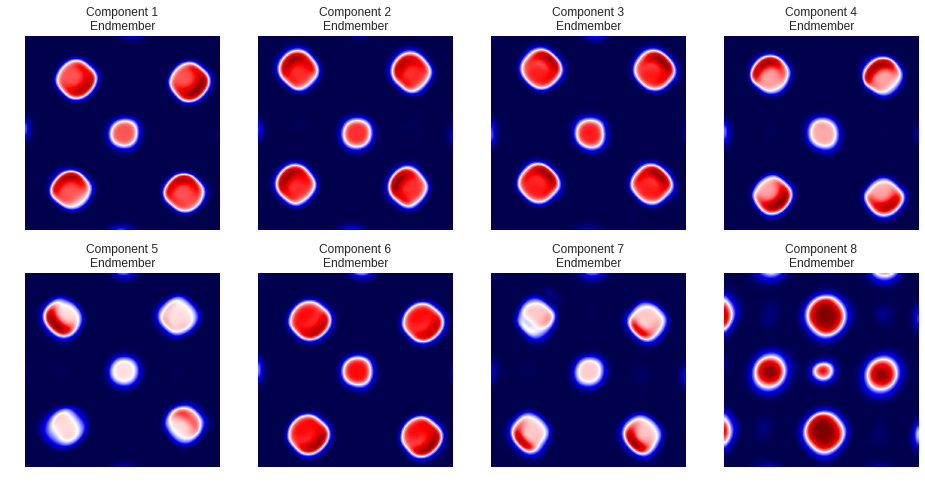

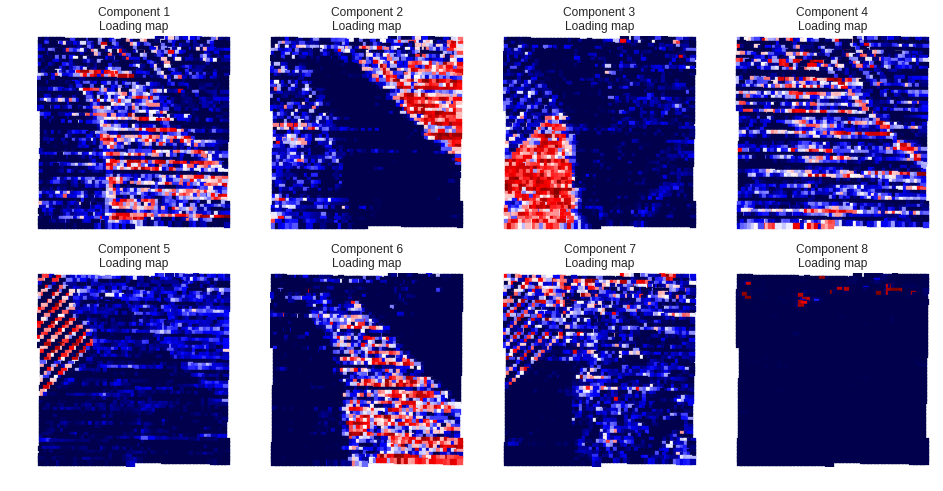

In [0]:
components_total = [3, 4, 5, 6, 7, 8]
img_w, img_h = network_output.shape[1:3]

for nc in components_total:
    # run nmf analysis
    nmf = decomposition.NMF(
        n_components = nc, random_state=42, max_iter=1000)
    X_vec_t = nmf.fit_transform(X_vec)
    components = nmf.components_
    components = components.reshape(nc, w, h, ch)
    
    rows = int(np.ceil(float(nc)/5))
    cols = int(np.ceil(float(nc)/rows))
    y, x = com_.T
    
    print('NUMBER OF COMPONENTS: ' + str(nc))
    # plot extracted endmembers
    gs1 = gridspec.GridSpec(rows, cols)
    fig1 = plt.figure(figsize=(4*cols, 4*(1+rows//2)))   
    for i in range(nc):
        ax1 = fig1.add_subplot(gs1[i])
        ax1.imshow(components[i,:, :, 0]+components[i, :, :, 1],
                   cmap='seismic', Interpolation='Gaussian')
        ax1.set_aspect('equal')
        ax1.axis('off')
        ax1.set_title('Component '+str(i+1)+'\nEndmember')
    fig1.savefig(mdirectory+str(image_filename[0:-4])+'-NMFmodes-n_cells'
                 +str(sc)+'-n_components'+str(nc)+'.png')
    plt.show()
    
    # plot loading maps
    gs2 = gridspec.GridSpec(rows, cols)
    fig2 = plt.figure(figsize=(4*cols, 4*(1+rows//2)))   
    for i in range(nc):
        ax2 = fig2.add_subplot(gs2[i])
        ax2.scatter(x, y, c=X_vec_t[:,i], cmap='seismic', marker='s', s=32)
        ax2.set_xlim(0, img_w)
        ax2.set_ylim(img_h, 0)
        ax2.set_aspect('equal')
        ax2.axis('off')
        ax2.set_title('Component '+str(i + 1)+'\nLoading map')
    fig2.savefig(mdirectory+str(image_filename[0:-4])+'-NMFmaps-n_cells-'
                 +str(sc)+'-n_components'+str(nc)+'.png')
    plt.show()       

### Independent component analysis

We run the independent component analysis (ICA) on the same set of data and display eigenvectors with the associated loading maps:

NUMBER OF COMPONENTS: 3


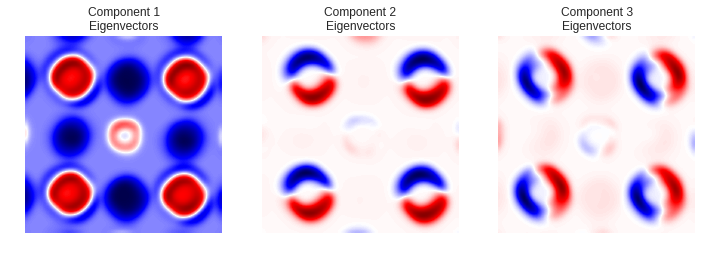

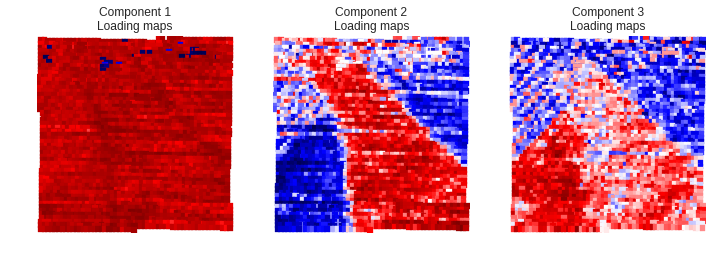

NUMBER OF COMPONENTS: 4


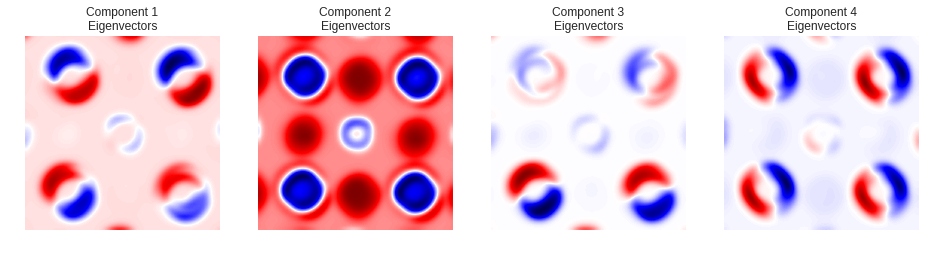

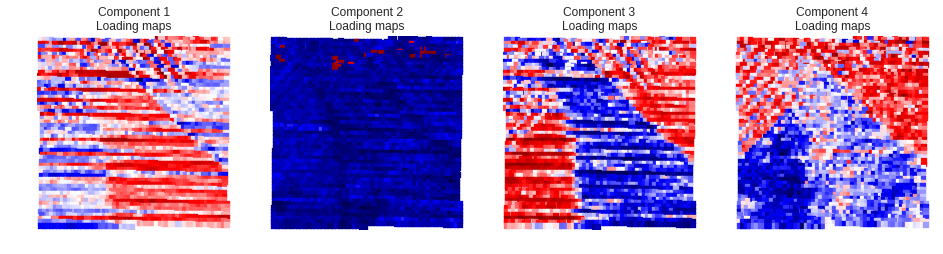

NUMBER OF COMPONENTS: 5


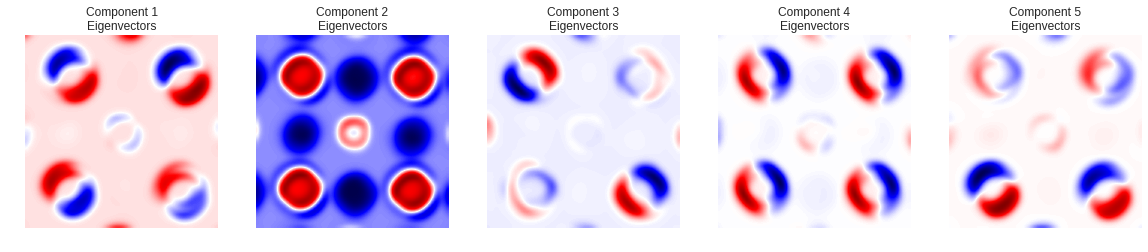

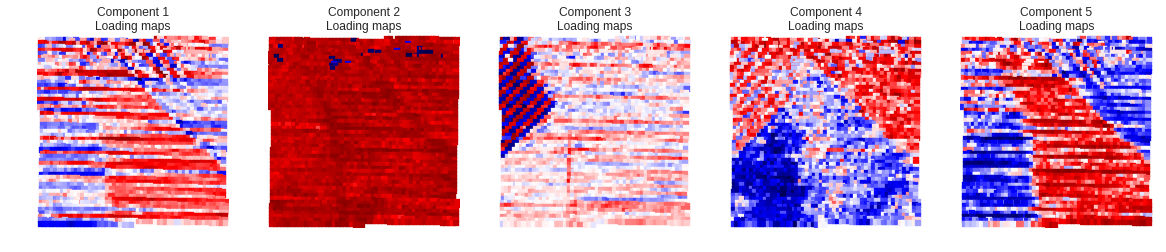

NUMBER OF COMPONENTS: 6


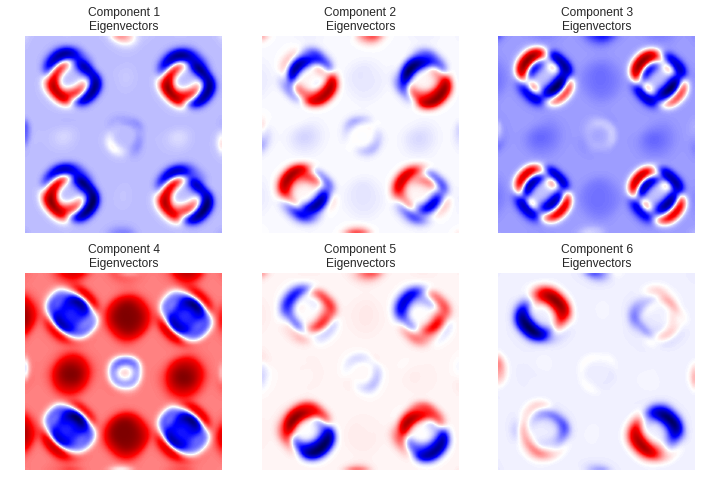

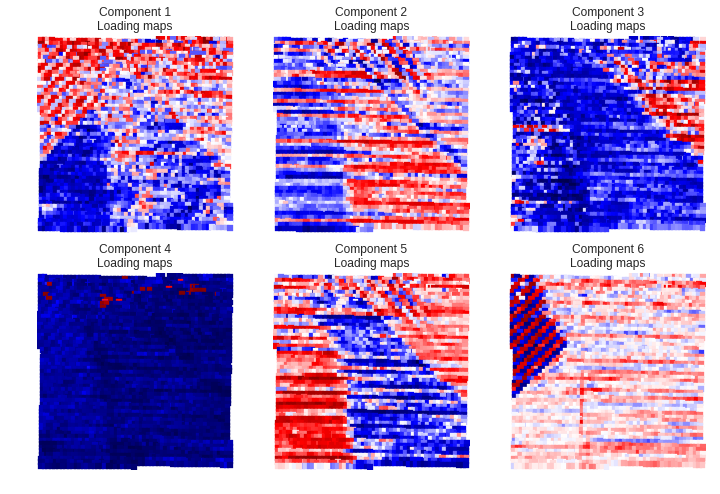

NUMBER OF COMPONENTS: 7


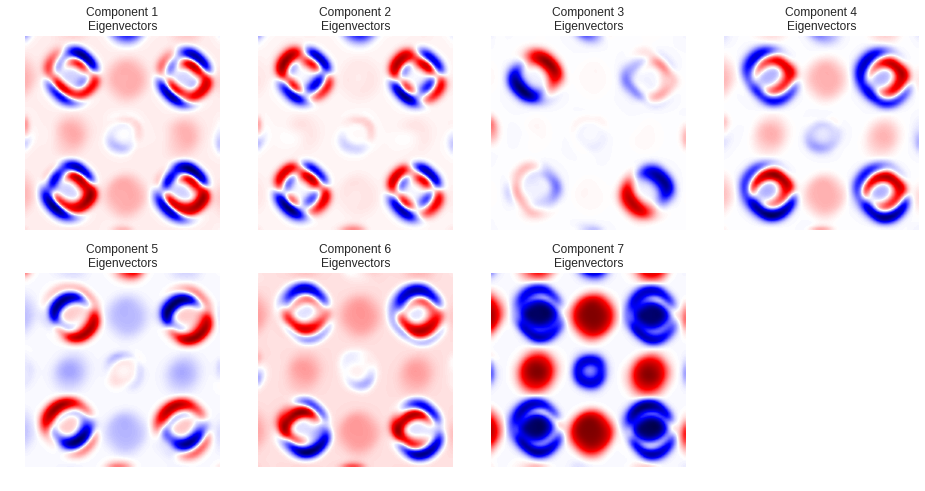

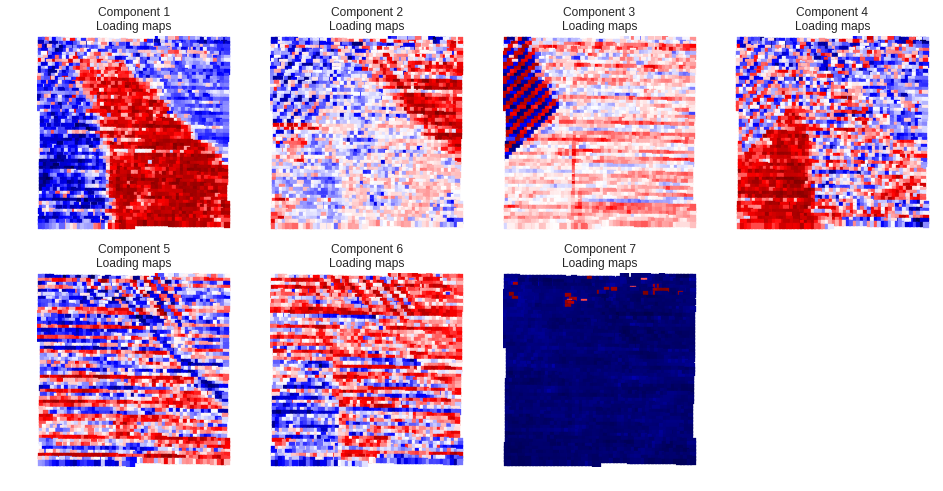

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


NUMBER OF COMPONENTS: 8


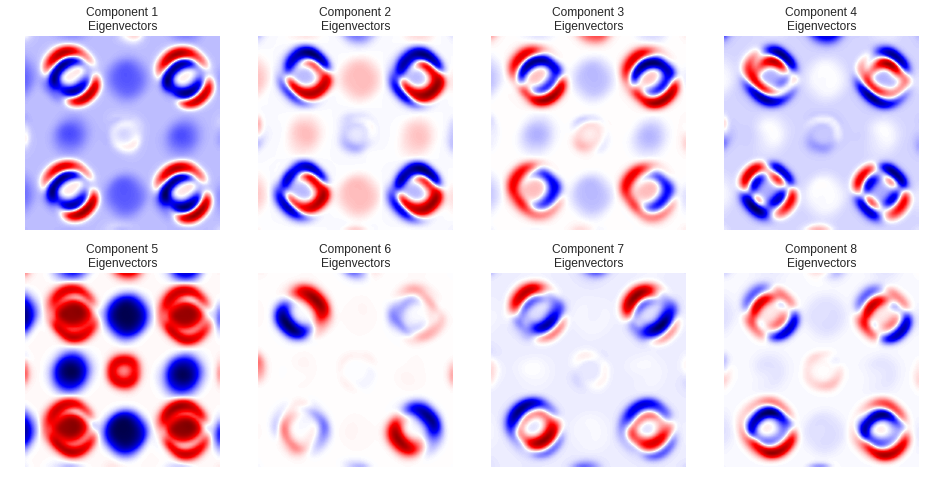

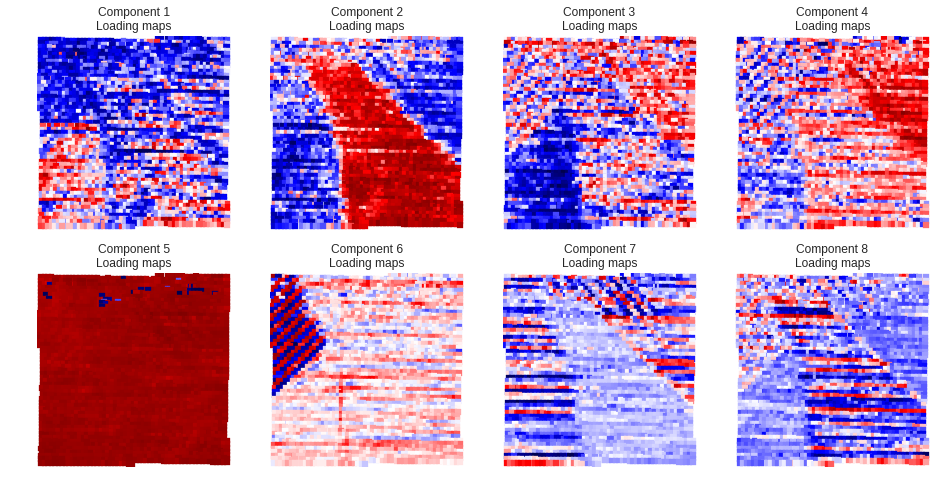

In [0]:
components_total = [3, 4, 5, 6, 7, 8]
img_w, img_h = network_output.shape[1:3]

for nc in components_total:
    # run ica analysis
    ica = decomposition.FastICA(
        n_components = nc, random_state=42, max_iter=1000)
    X_vec_t = ica.fit_transform(X_vec)
    components = ica.components_
    components = components.reshape(nc, w, h, ch)
    
    rows = int(np.ceil(float(nc)/5))
    cols = int(np.ceil(float(nc)/rows))
    y, x = com_.T
    
    print('NUMBER OF COMPONENTS: ' + str(nc))
    # plot ica eigenvectors
    gs1 = gridspec.GridSpec(rows, cols)
    fig1 = plt.figure(figsize=(4*cols, 4*(1+rows//2)))   
    for i in range(nc):
        ax1 = fig1.add_subplot(gs1[i])
        ax1.imshow(components[i, :, :, 0]+components[i, :, :, 1],
                   cmap='seismic', Interpolation='Gaussian')
        ax1.set_aspect('equal')
        ax1.axis('off')
        ax1.set_title('Component ' + str(i + 1) + '\nEigenvectors')
    fig1.savefig(mdirectory+str(image_filename[0:-4])+'-ICAmodes-n_cells'
                 +str(sc)+'-n_components'+str(nc)+'.png')
    plt.show()
    
    # plot loading maps
    gs2 = gridspec.GridSpec(rows, cols)
    fig2 = plt.figure(figsize=(4*cols, 4*(1+rows//2)))   
    for i in range(nc):
        ax2 = fig2.add_subplot(gs2[i])
        ax2.scatter(x, y, c=X_vec_t[:,i], cmap='seismic', marker='s', s=32)
        ax2.set_xlim(0, img_w)
        ax2.set_ylim(img_h, 0)
        ax2.set_aspect('equal')
        ax2.axis('off')
        ax2.set_title('Component '+str(i + 1)+'\nLoading maps')
    fig2.savefig(mdirectory+str(image_filename[0:-4])+'-ICAmaps-n_cells-'
                 +str(sc)+'-n_components'+str(nc)+'.png')
    plt.show() 

### Gaussian mixture model

Finally, we will apply a Gaussian mixture model to our dataset and plot the means of the extracted mixture components and the corresponding abundance (loading) maps:

In [0]:
clusters = [3, 4, 5, 6, 7, 8]
img_w, img_h = network_output.shape[1:3]
colors = color_list()

for nc in clusters:
    # GMM analysis: fit the "training data"
    clf = mixture.GaussianMixture(
        n_components=nc, covariance_type='diag',
        random_state=10).fit(X_vec)
    # predict class of each sample in the dataset
    labels = clf.predict(X_vec)
    # find means of the mixture centroids
    means = clf.means_
    means = means.reshape(nc, w, h, ch)
    
    cols = 3
    rows = int(np.ceil(float(nc/cols)))
    y, x = com_.T
    
    print('NUMBER OF COMPONENTS: ' + str(nc))
    # plot the extracted centroid means
    gs1 = gridspec.GridSpec(rows, cols)
    fig1 = plt.figure(figsize=(4*cols, 4*rows))   
    for idx, img in enumerate(means):
        ax1 = fig1.add_subplot(gs1[idx])
        ax1.imshow(img[:, :, 0]+img[:, :, 1],
                   cmap='seismic', Interpolation='Gaussian')
        ax1.set_title('Mean of mixture component '+str(idx+1))
        ax1.tick_params(color=colors[idx], labelcolor=colors[idx])
        for spine in ax1.spines.values():
            spine.set_edgecolor(colors[idx])
            spine.set_linewidth(4)
        ax1.grid(False)
        ax1.set_xticks([])
        ax1.set_yticks([])       
    fig1.savefig(mdirectory+str(image_filename[0:-4])+'-GMMmeans-n_cells'
                 +str(sc)+'-n_components'+str(nc)+'.png')
    plt.show()
    
    # plot the correspondong abundance maps
    fig, ax2 = plt.subplots(1, 1, figsize=(4*cols, 4*cols))
    for k in range(com_.shape[0]):
        ax2.scatter(com_[k][1], com_[k][0],
                    c = colors[labels[k]], marker='s', s=64)
    ax2.set_xlim(0, img_w)
    ax2.set_ylim(img_h, 0)
    ax2.set_aspect('equal')
    ax2.set_title('\nLoading map. Number of components: '+str(nc))
    for spine in ax2.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
            ax2.grid(False)
            ax2.set_xticks([])
            ax2.set_yticks([])  
    fig2.savefig(mdirectory+str(image_filename[0:-4])+
                 '-GMMmap-n_cells-'+'-n_components'+str(nc)
                 +str(sc)+'.png')
    plt.show()

# Download the output

Finally, download the output of this analysis to a local machine:

In [0]:
!zip -r output.zip $mdirectory
if not int(nbtype[0]):
    files.download('output.zip')

  adding: Figures/ (stored 0%)
  adding: Figures/22.06.02_2-NMFmaps-n_cells-1-n_components3.png (deflated 1%)
  adding: Figures/22.06.02_2-PCAfeaturespace-n_cells1.png (deflated 2%)
  adding: Figures/22.06.02_2-network_output.png (deflated 3%)
  adding: Figures/22.06.02_2-ICAmaps-n_cells-1-n_components5.png (deflated 1%)
  adding: Figures/22.06.02_2-ICAmaps-n_cells-1-n_components3.png (deflated 1%)
  adding: Figures/22.06.02_2-KMeans_on_PCA-n_clusters3-n_PCAcomponents4-n_cells1.png (deflated 3%)
  adding: Figures/22.06.02_2-NMFmodes-n_cells1-n_components8.png (deflated 2%)
  adding: Figures/22.06.02_2-NMFmaps-n_cells-1-n_components6.png (deflated 1%)
  adding: Figures/22.06.02_2-NMFmodes-n_cells1-n_components6.png (deflated 1%)
  adding: Figures/22.06.02_2-ICAmaps-n_cells-1-n_components7.png (deflated 1%)
  adding: Figures/22.06.02_2-ICAmodes-n_cells1-n_components6.png (deflated 1%)
  adding: Figures/22.06.02_2-PCAmaps-n_cells-1-n_components4.png (deflated 1%)
  adding: Figures/22.06.0